In [1]:
# Install dependancies
# Don't run this if you installed via requirements.txt
# %pip install gymnasium numpy tensorflow matplotlib pygame shapely pydot graphviz
# %pip install -r requirements.txt

In [2]:
# Imports
%load_ext autoreload
%autoreload 2

# import gymnasium as gym
import numpy as np
from random import randint
import inspect
from Cope import percent
import random
import time
from pathlib import Path
import matplotlib.pyplot as plt
from SquareEnv2 import space2MultiPolygon, SquareEnv
# import subprocess
# from rich import print as rprint
# from IPython.display import HTML, display
# from gymnasium import spaces
import itertools as it
# import base64
# from PIL import Image


In [3]:
# Configuration & Enviorment
env = SquareEnv(
    N=11,
    search_space=5.5,
    render_mode="pygame",
    # render_mode="shapely",
    shift_rate=.05,
    rot_rate=.03,
    max_steps=1_000_000,
    bound_method='mixed',
    disallow_overlap=True,
    boundary=0,
    max_overlap=5,
    start_config='valid',
    screen_size=(300, 400),
)

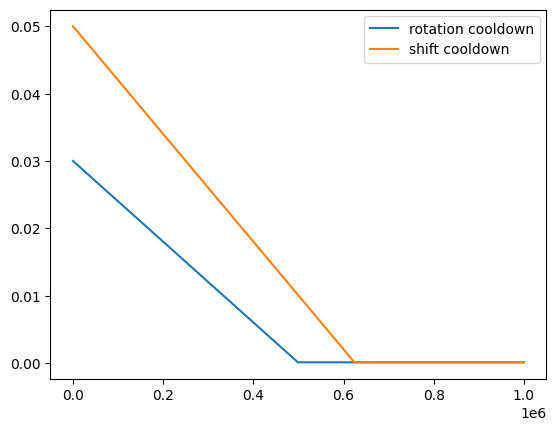

In [4]:
# Config
# How many resets we're running for.
total_episodes = 5

# Percent
rand = .4
# The starting rates will always be the highest
rot = env.rot_rate
shift = env.shift_rate

_min_rand = .01 # percent
_min_rot = .0001
_min_shift = .0001

# How much we allow the probability to be modified, based on the score difference
rand_modify_limit = lambda rand: rand * .5

# The steps at which each phase starts and ends
overlap_phase = (-1, env.max_steps * 2)
overlap_phase_rand = rand

# cooldown functions
cooldown = True
rand_func  = lambda step: overlap_phase_rand if step > overlap_phase[0] and step < overlap_phase[1] else np.clip(-.0000004*step  + rand,  _min_rand, rand)
rot_func   = lambda step: np.clip(-.00000006*step + rot,   _min_rot, rot)
shift_func = lambda step: np.clip(-.00000008*step + shift, _min_shift, shift)

x = np.array(range(1, env.max_steps if env.max_steps > 1 else 100_000))
# plt.plot(x, list(map(rand_func, x)), label='random cooldown')
plt.plot(x, rot_func(x), label='rotation cooldown')
plt.plot(x, shift_func(x), label='shift cooldown')
plt.legend()
plt.show()

In [5]:
# Show our configuration in the window
env.show_strings = [
    '-------------------------',
    'Env Config:',
    f'Number of Squares: {env.N}',
    f'Max Steps: {env.max_steps}',
    f'Max Overlap: {env.max_overlap}',
    f'Shift Rate: {env.shift_rate}',
    f'Rotation Rate: {env.rot_rate}',
    f'Start Config: {env.start_config}',
    f'Boundary: {env.boundary}',
    f'Bound Method: {env.bound_method}',
    '-------------------------',
]

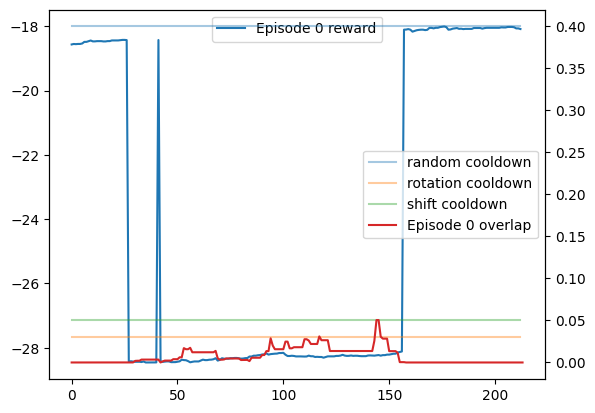

Best Reward yet:  -18.00918656721807
Best State:
[4.30212267 1.25706372 1.17822961 1.93061951 2.01811629 0.03580821
 0.36965831 2.03610663 1.21195383 3.04002205 2.2628493  0.01366592
 0.32066123 3.71129114 0.59790795 2.02080201 3.80792288 0.
 0.6238785  0.84364238 1.39957841 5.47364831 2.08371548 1.10810675
 4.40601712 2.85270943 1.42394178 0.85114097 5.28693055 1.37671417
 2.40389359 5.01605269 0.26843633]


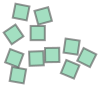

SystemExit: 0

/home/zeke/Software/miniconda3/envs/tf2/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:
# %%capture run
#! REMEMBER: Don't forget to increment the run name
# Main Loop
# To store reward history of each episode (for plotting)
reward_lists = []
overlap_lists = []
best_state_yet = None
best_reward_yet = -10000000000
env.disallow_overlap = True

try:
    # Run through `total_episodes` number of enviorment resets
    for ep in range(total_episodes):
        prev_state, _ = env.reset()
        prev_reward = env._get_reward()
        episodic_reward = 0
        reward_lists.append([])
        overlap_lists.append([0])
        start_time = time.time_ns()

        # Run/step through a single episodes
        for step in it.count(1):
            env.render()
            _rand = rand_func(step) if cooldown else rand
            _shift = shift_func(step) if cooldown else shift
            _rot = rot_func(step) if cooldown else rot
            _overlap_phase = step > overlap_phase[0] and step < overlap_phase[1]

            if _overlap_phase:
                env.disallow_overlap = False

            # Make a random action
            action = np.zeros((env.N, 3))
            action[randint(0, env.N-1)] = [
                random.uniform(-_shift, _shift),
                random.uniform(-_shift, _shift),
                random.uniform(-_rot, _rot),
            ]
            action = action.flatten()

            # Recieve state and reward from environment.
            state, reward, done, _, info = env.step(action)

            _rand_limit = rand_modify_limit(_rand)
            _chance = _rand + np.clip((prev_reward - reward) * 10, -_rand_limit, _rand_limit)
            # If we're overlapping more than we were before, minimize the odds that we'll keep the movement
            # NOTE: This can't be 0, or else once we overlap during the overlap phase, we won't be able to get out
            if not _overlap_phase and info['overlap'] > overlap_lists[ep][-1]:
                _chance = _rand - _rand_limit
            if (
                (
                    (info['overlap'] > 0 and not _overlap_phase)
                    or
                    reward < prev_reward
                )
                # modify the chance of accepting the change based on the amount of reward difference
                and not percent(_chance)
            ):
                # Step back
                state, reward, done, _, info = env.step(-action)

            # If we've finished the overlap phase, and we've gotten to a point where we're no longer
            # overlapping, disable overlap again
            if not env.disallow_overlap and not info['overlap']:
                env.disallow_overlap = True

            # ------------------ Not part of the algorithm --------------------
            reward_lists[ep].append(reward)
            overlap_lists[ep].append(info['overlap'])

            if best_reward_yet < reward:
                best_state_yet = state
                best_reward_yet = reward

            episodic_reward += reward
            env.print['e'] = f'Episode {env.reset_count}/{total_episodes}:'
            env.print['step'] = f'Step: {step:.0f}'
            env.print['reward'] = f'Reward: {reward:.3f}'
            env.print['overlap'] = f'Overlap: {info["overlap"]:.5f}'
            env.print['len'] = f'Side Length: {info["len"]:.1f}'
            env.print['wasted'] = f'Wasted Space: {info["wasted"]:.1f}'
            env.print['_rand'] = f'annealing coeff: {_rand:.5f}'
            env.print['_shift'] = f'shift rate: {_shift:.5f}'
            env.print['_rot'] = f'rotation rate: {_rot:.5f}'
            env.print['avg reward'] = f'Avg. Reward for This Episode: {episodic_reward/step:.2f}'
            env.print['phase'] = f"Phase: {'Overlap' if _overlap_phase else 'Main'}"
            env.print['eee'] = f'_rand: {_chance:.2%}'
            env.print['j'] = f'{((time.time_ns() - start_time)/1000_000) / step:.2f}ms / step'

            if done: break

            prev_state = state
            prev_reward = reward

finally:
    env.close()
    if best_reward_yet is not None and True:
        env.display()

        fig, ax1 = plt.subplots()

        for ep, i in enumerate(reward_lists):
            ax1.plot(i, label=f'Episode {ep} reward')

        ax2 = ax1.twinx()
        x = np.array(range(len(max(reward_lists, key=len))))
        ax2.plot(x, list(map(rand_func, x)), label='random cooldown', alpha=.4)
        ax2.plot(rot_func(x), label='rotation cooldown', alpha=.4)
        ax2.plot(shift_func(x), label='shift cooldown', alpha=.4)
        for ep, i in enumerate(overlap_lists):
            ax2.plot(i, label=f'Episode {ep} overlap')

        ax1.legend()
        ax2.legend()
        # ax1.vlines(overlap_phase, -22, -3)
        plt.show()
        print('Best Reward yet: ', best_reward_yet)
        print('Best State:')
        print(best_state_yet)

        display(space2MultiPolygon(best_state_yet.reshape((env.N,3)), 1))

        # save_output(run, 'run9')


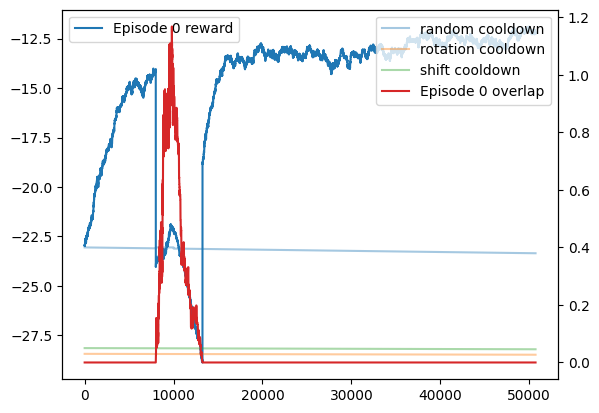